# Εργασία 3 ερώτημα Β


Αν θέλουμε να συνδέσουμε το πρόγραμμα με το google drive ξεσχολιάζουμε τις δύο πρώτες γραμμές.
Στην τρίτη γραμμή βάζουμε το path του dataset που θα χρησιμοποιηθεί για training.

In [3]:

from google.colab import drive
drive.mount("/content/drive")

dataset = r'/content/nasdaq2007_17.csv'

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from datetime import datetime

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.metrics import f1_score


from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout

from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model

import random
import os
import tensorflow as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def reproducibleResults(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

reproducibleResults(0)

Διάβασμα του dataset 

In [4]:
import pandas as pd
import numpy as np

df_dataset = pd.read_csv(dataset,delimiter='\t',header = None)
df_dataset.dropna
df_dataset.drop(df_dataset.columns[0],axis=1, inplace=True)
print(df_dataset)

        1        2        3        4     ...    3647    3648    3649    3650
0    11.1440  10.4710  10.8280  10.6980  ...   68.25   68.11   67.47   66.81
1    47.4580  45.8700  46.2490  47.8520  ...   46.97   45.89   43.33   43.01
2    13.8800  12.9700  13.2900  13.0900  ...   72.22   71.16   70.19   70.56
3     1.2037   1.1589   1.1385   1.1437  ...  174.18  175.61  175.25  174.67
4    13.9910  13.4340  13.1950  13.4150  ...   74.91   75.01   75.27   75.00
..       ...      ...      ...      ...  ...     ...     ...     ...     ...
354  17.2850  16.9010  17.0160  17.4210  ...   64.38   64.52   65.56   65.58
355  36.3880  35.2030  35.7070  35.1040  ...   28.59   29.37   29.27   29.17
356   8.2660   8.3172   8.2781   8.3591  ...   81.01   81.13   79.53   79.59
357  46.3950  45.8150  42.1810  41.5820  ...  108.72  109.17  111.84  110.75
358  47.6690  46.6680  46.5700  46.9740  ...   44.88   44.55   43.97   43.93

[359 rows x 3650 columns]


Μετατροπή του dataset σε numpy και ένωση όλων των χρονοσειρών σε μία με την εντολή flatten()

In [ ]:
df_data = df_dataset.to_numpy()

df_data=df_data.flatten()
print(df_data.shape)
df_data = df_data.reshape(df_data.shape[0],1)
print(df_data.shape)


(1306700,)
(1306700, 1)


Κρατάμε 95% της χρονοσειράς για training και 5% για testing ενώ κάνουμε και scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

train_size = int(len(df_data) * 0.95)
test_size = len(df_data) - train_size
train, test = df_data[0:train_size], df_data[train_size:len(df_data)]

scaler = StandardScaler()

scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)


print(train.shape, test.shape)

(1241365, 1) (65335, 1)


Τρέχουμε αυτό το κελί αν θέλουμε να αποθηκεύσουμε τον scaler και φτιάχνουμε το μονοπάτι

In [ ]:
from pickle import dump

dump(scaler, open('/content/drive/MyDrive/Colab Notebooks/project_3/scaler_3b.pkl', 'wb'))

Συναρτήση για τον χωρισμό των timesteps

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)



Χωρισμός των set σε timesteps και προετοιμασια για να μπουν στο μοντέλο έχοντας διαστάσεις  [samples, timesteps, n_features] όπου n_features = 1

In [ ]:
TIME_STEPS = 30
X_train = []
y_train = []

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset( train,train,TIME_STEPS)

# reshape to [samples, time_steps, n_features]
X_test, y_test = create_dataset( test,test,TIME_STEPS)

print(X_train.shape)
print(y_train.shape)
y_train.reshape(y_train.shape[0])
y_test.reshape(y_test.shape[0])

print(X_train.shape)


(1241335, 30, 1)
(1241335, 1)
(1241335, 30, 1)


To μοτέλο στο οποίο καταλήξαμε μετά από πολλές δοκιμές οι οποίες περιγράφται στο readme

In [ ]:

model = Sequential()
model.add(LSTM(
units=64,
input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(rate=0.5))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.5))
model.add(
TimeDistributed(
Dense(units=1)
)
)
model.compile(loss='mae', optimizer='adam')

model.summary()

history = model.fit(
X_train, y_train,
epochs=10,
batch_size=1024,
validation_split=0.1,
shuffle=False
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                                

Τρέχουμε το κελί αν θέλουμε να σώσουμε το μοντέλο και αλλάζουμε το μονοπάτι

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/project_3/autoencoder3_b')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_3/autoencoder3_b/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project_3/autoencoder3_b/assets


2041/2041 [==============================] - 21s 10ms/step - loss: 4.4489e-04


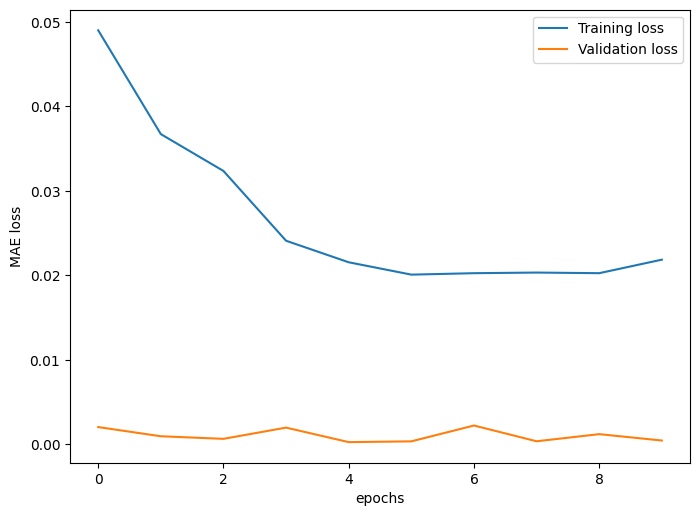

In [ ]:
figure(figsize=(8,6),dpi=100)
model.evaluate(X_test, y_test)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.ylabel('MAE loss')
plt.xlabel('epochs');
plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3_b_outputs/testt_final_train_eval.png')
plt.legend();


(1241335, 30, 1)


No handles with labels found to put in legend.


Reconstruction error threshold: 0.0183445230227856


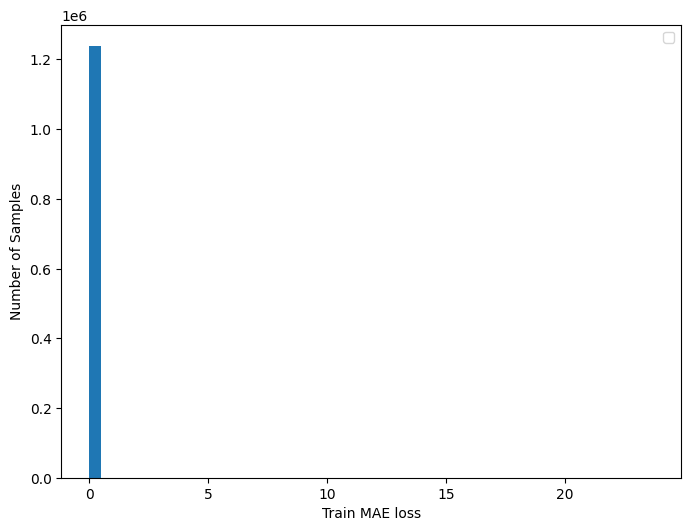

In [ ]:
figure(figsize=(8,6),dpi=100)

X_train_pred = model.predict(X_train)
print(X_train_pred.shape)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
plt.legend();

threshold = np.average(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')


plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3_b_outputs/testt_train_loss.png')



(65305, 30, 1)


No handles with labels found to put in legend.


(65305, 1)
(65305, 30, 1)


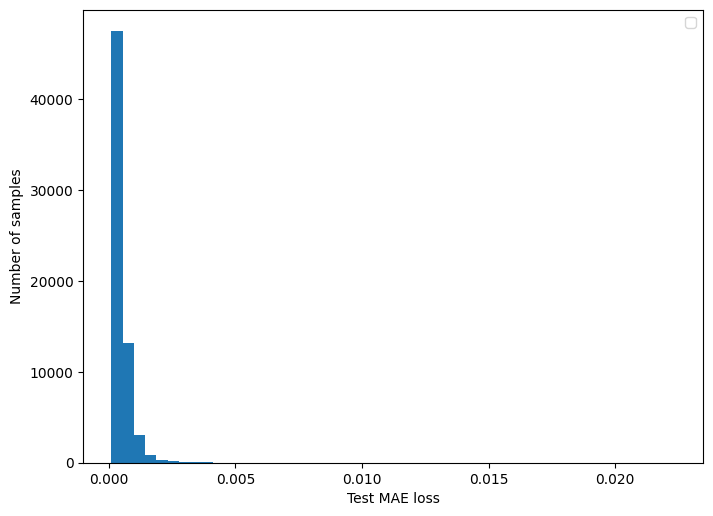

In [ ]:
figure(figsize=(8,6),dpi=100)
print(X_test.shape)

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
plt.legend();

print(test_mae_loss.shape)

#sc = scaler.inverse_transform(X_test_pred)
print(X_test_pred.shape)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3_b_outputs/3_final_test_loss.png')


Θέτουμε threshold ανάλογα με το διάγραμμα στη δεύτερη γραμμή

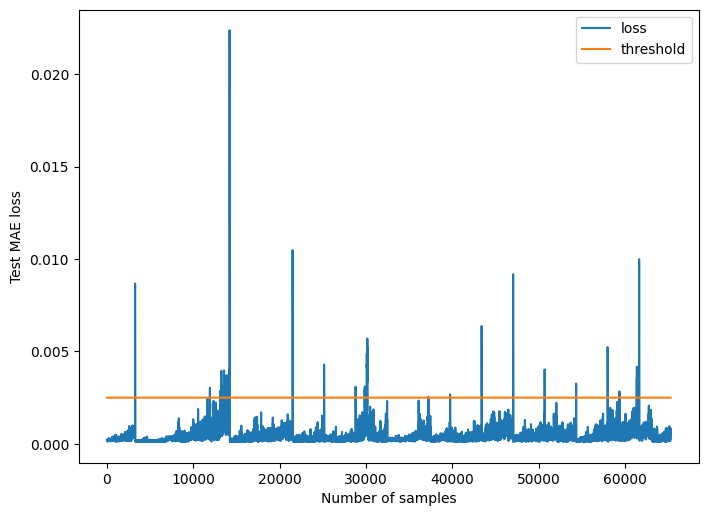

In [ ]:
import plotly.graph_objects as go

threshold = 0.0025
figure(figsize=(8,6),dpi=100)

test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]

plt.plot(test_score_df['loss'], label='loss')
plt.plot(test_score_df['threshold'],label = 'threshold')
plt.ylabel('Test MAE loss')
plt.xlabel('Number of samples');
plt.legend();

plt.savefig('/content/drive/MyDrive/Colab Notebooks/project_3/project_3_b_outputs/3_final_treshold_loss.png')


Φτιάχνουμε τα indexes στις γραμμές με τις ανωμαλίες που βρέθηκαν ώστε να μπορέσουμε να τις βάλουμε στο διάγραμμα με την τιμή της μετοχής

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.reset_index(drop = True)
data_top =  list(anomalies.index)
anomalies

,0,loss,threshold,anomaly,Close
3256,-0.057519,0.004769,0.0025,True,-0.057519
3257,-0.057550,0.007438,0.0025,True,-0.057550
3258,-0.057553,0.008675,0.0025,True,-0.057553
3259,-0.057550,0.008624,0.0025,True,-0.057550
3260,-0.057549,0.007749,0.0025,True,-0.057549
...,...,...,...,...,...
61672,-0.051716,0.003738,0.0025,True,-0.051716
61673,-0.051687,0.003414,0.0025,True,-0.051687
61674,-0.051738,0.003134,0.0025,True,-0.051738
61675,-0.051646,0.002892,0.0025,True,-0.051646


Κάνουμε reshape και unscaling για να φτιάξουμε το διάγραμμα με την τιμή της μετοχής και τις ανωμαλίες

In [ ]:
if len(anomalies) != 0:

  fig = go.Figure()

  close = test_score_df['Close'].to_numpy().reshape(test_score_df.shape[0],1)
  c=scaler.inverse_transform(close)
  a_close = anomalies['Close'].to_numpy().reshape(anomalies.shape[0],1)
  a = scaler.inverse_transform(a_close)
  
  x = np.arange(len(c))
  x = x.reshape(len(x),1)

  test_score_df['Close'] = c
  test_score_df['Dates'] = x

  anomalies.loc[:,['Close']] = a
  anomalies.loc[:,['Dates']] = data_top
  
  figure(figsize=(10,8),dpi=100)

  fig.add_trace(go.Scatter( x = test_score_df['Dates'] ,y=test_score_df['Close'], name='Close price'))
  fig.add_trace(go.Scatter(x=anomalies['Dates'], y= anomalies['Close'], mode='markers', name='Anomaly'))
  fig.update_layout(showlegend=True, title='Detected anomalies')

  fig.show()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:659: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

<Figure size 1000x800 with 0 Axes>

Αν θέλουμε να σώσουμε το διάγραμμα κάπου τρέχουμε να επόμενα δύο κελιά και φτιάχνουμε το μονοπάτι στο 2ο κελί

In [ ]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4



In [ ]:

fig.write_image('/content/drive/MyDrive/Colab Notebooks/project_3/project_3_b_outputs/3_final_0.0025_anomalies.png')
